# Gaussian Processes Tutorial - Regression

It took me a while to truly get my head around Gaussian Processes (GPs). There are some great resources out there to learn about them - [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/), [mathematicalmonk's youtube series](https://www.youtube.com/watch?v=vU6AiEYED9E), [Mark Ebden's high level introduction](https://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf) and [scikit-learn's implementations](https://github.com/scikit-learn/scikit-learn/tree/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/gaussian_process) - but no single resource I found providing:

1. A good high level exposition of what GPs actually are.
2. Enough mathematical detail to fully understand how they work.
3. A clear step-by-step guide on implementing them efficiently.

This post aims to fix that by drawing the best bits from each of the resources mentioned above, but filling in the gaps, and structuring, explaining and implementing it all in a way that I think makes most sense. I hope it helps, and feedback is very welcome.

By the way, if you are reading this on my blog, you can access the raw notebook to play around with here on [github](https://github.com/michaeloneill/GaussianProcesses). If you are on github already, here is my [blog](https://michaeloneill.github.io/)!

## Recap of regression

Consider the standard regression problem. We have some observed data $\mathcal{D} = [(\mathbf{x}_1, y_1) \dots (\mathbf{x}_n, y_n)]$ with $\mathbf{x} \in \mathbb{R}^D$ and $y \in \mathbb{R}$. We assume that each observation $y$ can be related to an underlying function $f(\mathbf{x})$ through a Gaussian noise model:

$$y = f(\mathbf{x}) + \mathcal{N}(0, \sigma_n^2)$$

The aim is to find $f(\mathbf{x})$, such that given some new test point $\mathbf{x}_*$, we can accurately estimate the corresponding $y_*$. If we assume that $f(\mathbf{x})$ is linear, then we can simply use the least-squares method to draw a line-of-best-fit and thus arrive at our estimate for $y_*$.

Of course the assumption of a linear model will not normally be valid. To lift this restriction, a simple trick is to project the inputs $\mathbf{x} \in \mathcal{R}^D$ into some higher dimensional space $\mathbf{\phi}(\mathbf{x}) \in \mathcal{R}^M$, where $M > D$, and then apply the above linear model in this space rather than on the inputs themselves. For example, a scalar input $x \in \mathcal{R}$ could be projected into the space of powers of $x$: $\phi({x}) = (1, x, x^2, x^3, \dots x^{M-1})^T$. By applying our linear model now on $\phi(x)$ rather than directly on the inputs $x$, we would implicitly be performing polynomial regression in the input space. 

By selecting alternative components (a.k.a basis functions) for $\phi(\mathbf{x})$ we can perform regression of more complex functions. But how do we choose the basis functions? In a Gaussian Process Regression (GPR), we need not specify the basis functions explicitly. Rather, we are able to represent $f(\mathbf{x})$ in a more general and flexible way, such that the data can have more influence on its exact form. This is a key advantage of GPR over other types of regression.

## What is a GP?

A GP simply generalises the definition of a multivariate Gaussian distribution to incorporate infinite dimensions: a GP is a set of random variables, any finite subset of which are multivariate Gaussian distributed (these are called the _finite dimensional distributions_, or f.d.ds, of the GP). More formally, for any index set $\mathcal{S}$, a GP on $\mathcal{S}$ is a set of random variables $\{z_s: s \in \mathcal{S}\}$ s.t. $\forall n \in \mathcal{N}, \forall s_1, \dots s_n \in \mathcal{S}$, $(z_{s_1} \dots z_{s_n})$ is multivariate Gaussian distributed.  The definition doesn't actually exclude finite index sets, but a GP defined over a finite index set would simply be a multivariate Gaussian distribution, and would normally be named as such. In our case the index set $\mathcal{S} = \mathcal{X}$ is the set of all possible input points $\mathbf{x}$, and the random variables $z_s$ are the function values $f_\mathbf{x} \overset{\Delta}{=} f(\mathbf{x})$ corresponding to all possible input points $\mathbf{x} \in \mathcal{X}$. 

Whilst a multivariate Gaussian distribution is completely specified by a single finite dimensional mean vector and a single finite dimensional covariance matrix, in a GP this is not possible, since the f.d.ds in terms of which it is defined can have any number of dimensions. Instead we specify the GP in terms of an _element-wise_ mean function and and _element-wise_ covariance function (a.k.a _kernel function_):
\begin{align*} 
m(\mathbf{x}) &= \mathbb{E}[f(\mathbf{x})] \\
k(\mathbf{x}_i, \mathbf{x}_j) &= \mathbb{E}[(f(\mathbf{x}_i) - m(\mathbf{x}_i))(f(\mathbf{x}_j) -m(\mathbf{x}_j))], \end{align*}
and write the GP as 
$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}_i, \mathbf{x}_j)).$$

The mean vectors and covariance matrices of the f.d.ds can be constructed simply by applying $m(\mathbf{x})$ and $k(\mathbf{x}_i, \mathbf{x}_j)$ element-wise. For example, the f.d.d over $\mathbf{f} = (f_{\mathbf{x}_1}, \dots f_{\mathbf{x}_n})$ would be $ \mathbf{f} \sim \mathcal{N}(\bar{\mathbf{f}}, K(X, X))$, with

\begin{align*}
\bar{\mathbf{f}} &= \begin{pmatrix} m(\mathbf{x}_1) \\ \vdots \\ m(\mathbf{x}_n) \end{pmatrix} \\
K(X, X) &= \begin{bmatrix} k(\mathbf{x}_1, \mathbf{x}_1) & \ldots & k(\mathbf{x}_1, \mathbf{x}_n) \\
\vdots & \ddots & \vdots \\
k(\mathbf{x}_n, \mathbf{x}_1) & \ldots & k(\mathbf{x}_n, \mathbf{x}_n) \end{bmatrix}.
\end{align*}
Here, and below, we use $X \in \mathbb{R}^{n \times D}$ to denote the matrix of input points (one row for each input point). Any kernel function is valid so long it constructs a valid covariance matrix i.e. one that is positive semi-definite. We explore the use of three valid kernel functions below.

## Gaussian Process Regression (GPR)

Now we know what a GP is, we'll now explore how they can be used to solve regression tasks. We are going to intermix theory with practice in this section, not only explaining the mathematical steps required to apply GPs to regression, but also showing how these steps can be be efficiently implemented. We will use simple visual examples throughout in order to demonstrate what's going on. What we will end up with is a simple GPR class to perform regression with, and hopefully a better understanding of what GPR is all about!

First some imports ...

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
np.random.seed(6)

Here is a skelton structure of the GPR class we are going to build.

In [2]:
class GPR():
    
    def __init__(self, kernel, optimizer='L-BFGS-B', noise_var=1e-8):
        self.kernel = kernel
        self.noise_var = noise_var
        self.optimizer = optimizer
    
    # 'Public' methods
    def sample_prior(self, X_test, n_samples):
        pass
    def sample_posterior(self, X_test, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass
    def optimize(self, theta, X_train, y_train):
        pass
    
    # 'Private' helper methods
    def _build_covariance_matrix(self, X1, X2=None):
        pass
    def _cholesky_factorise(y_cov):
        pass
    def _sample_multivariate_gaussian(y_mean, y_cov):
        pass

### Kernel functions

Before we start filling in the methods of our GPR class, we will also need to define some kernel functions to use with it. Here are 3 possibilities. 

\begin{align*}
\textit{Linear}: \quad &k(\mathbf{x}_i, \mathbf{x}_j) = \sigma_f^2\mathbf{x}_i^T \mathbf{x}_j \\
\textit{Squared Exponential}: \quad &k(\mathbf{x}_i, \mathbf{x}_j) = \text{exp} \left(\frac{-1}{2l^2} (\mathbf{x}_i - \mathbf{x}_j)^T (\mathbf{x}_i - \mathbf{x}_j)\right) \\
\textit{Periodic}: \quad &k(\mathbf{x}_i, \mathbf{x}_j) = \text{exp}\left(-\sin^2(2\pi f(\mathbf{x}_i - \mathbf{x}_j))\right)
\end{align*}

You can prove for yourself that each of these kernel functions is valid i.e. that it constructs a symmetric positive semi-definite covariance matrix. For example, the covariance matrix associated with the linear kernel is simply $\sigma_f^2XX^T$, which is indeed symmetric positive semi-definite. 

Each kernel function is associated with a parameter ($\sigma_f^2$, $l$ or $f$ in this case) that can be used to control the distribution over functions that it represents. To make this explicit, and simplify the code later on, we'll implement each kernel function as a class.

In [3]:
class Linear():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, x1, x2):
        return self.theta[0] * np.dot(x1.T, x2)

class SquaredExponential():
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale]
        self.bounds = [length_scale_bounds]
    def __call__(self, x1, x2):
        return np.exp(-1/(2*self.theta[0] ** 2) * np.dot((x1 - x2).T, (x1 - x2)))
    
class Periodic():
    def __init__(self, frequency=1.0, frequency_bounds=(1e-5, 1e5)):
        self.theta = [frequency]
        self.bounds = [frequency_bounds]
    def __call__(self, x1, x2):
        return np.exp(-np.sin(self.theta[0] * np.pi * (x1 - x2)) ** 2)

The kernel function is used to construct full covariance matrices of the f.d.ds. We write the following method to perform this task for us.

In [4]:
def _build_covariance_matrix(self, X1, X2=None):
    """ I realise that there is redundant computation here
    in the case that X1 and X2 are the same, but have
    kept it like this anyway for simplicity."""
    
    if X2 is None:
        X2 = X1
    C = np.zeros((X1.shape[0] , X2.shape[0]))
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            C[i, j] = self.kernel(X1[i], X2[j])
    return C
GPR._build_covariance_matrix = _build_covariance_matrix  # Add to class

### Sampling from the GP prior

To sample functions from our GP, we first specify the $n_*$ input points at which the sampled functions should be evaluated, and then draw from the corresponding $n_*\text{-variate}$ Gaussian distribution (f.d.d). This corresponds to sampling from the G.P _prior_, since we have not yet taken into account any observed data, only our prior belief (via the kernel function) as to which loose family of functions our target function belongs:

$$\mathbf{f}_* \sim \mathcal{N}\left(\mathbf{0}, K(X_*, X_*)\right).$$

Note that we have chosen the mean function $m(\mathbf{x})$ of our G.P prior to be $0$, which is why the mean vector in the f.d.d above is the zero vector $\mathbf{0}$. This is common practice and isn't as much of a restriction as it sounds, since the mean of the _posterior_ distribution is free to change depending on the observations it is conditioned on (see below). Technically the input points here take the role of test points and so carry the asterisk subscript to distinguish them from our training points $X$.

To implement this sampling operation we proceed as follows. First we build the covariance matrix $K(X_*, X_*)$ using the $\_\texttt{build}\_\texttt{covariance}\_\texttt{matrix}$ method we defined above. Next we compute the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $K(X_*, X_*)=LL^T$ (possible since $K(X_*, X_*)$ is symmetric positive semi-definite). For this we implement the following method:

In [5]:
def _cholesky_factorise(self, y_cov):
    try:
        L = np.linalg.cholesky(y_cov)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try increasing"
                  " the noise variance of the GP or using"
                  " a larger value for epsilon. "
                  % self.kernel,) + e.args
        raise
    return L
GPR._cholesky_factorise = _cholesky_factorise

Finally, we use the fact that in order generate Gaussian samples $\mathbf{z} \sim \mathcal{N}(\mathbf{m}, K)$ where $K$ can be decomposed as $K=LL^T$, we can first draw $\mathbf{u} \sim \mathcal{N}(\mathbf{0}, I)$, then compute $\mathbf{z}=\mathbf{m} + L\mathbf{u}$. $z$ has the desired distribution since $\mathbb{E}[\mathbf{z}] = \mathbf{m} + L\mathbb{E}[\mathbf{u}] = \mathbf{m}$ and $\text{cov}[\mathbf{z}] = L\mathbb{E}[\mathbf{u}\mathbf{u}^T]L^T = LL^T = K$. It is often necessary for numerical reasons to add a small number to the diagonal elements of $K$ before the Cholesky factorisation.

In [6]:
def _sample_multivariate_gaussian(self, y_mean, y_cov, n_samples=1, epsilon=1e-10):
    y_cov[np.diag_indices_from(y_cov)] += epsilon  # for numerical stability
    L = self._cholesky_factorise(y_cov)
    u = np.random.randn(y_mean.shape[0], n_samples)
    z = np.dot(L, u) + y_mean[:, np.newaxis]
    return z
GPR._sample_multivariate_gaussian = _sample_multivariate_gaussian

The below $\texttt{sample}\_\texttt{prior}$ method pulls together all the steps of the GP prior sampling process described above.

In [7]:
def sample_prior(self, X_test, n_samples=1):
    y_mean = np.zeros(X_test.shape[0])
    y_cov = self._build_covariance_matrix(X_test)
    return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples)
GPR.sample_prior = sample_prior

Let's compare the samples drawn from 3 different GP priors, one for each of the kernel functions defined above.

In [8]:
# First define input test points at which to evaluate the sampled functions
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis] # in general these can be > 1d, hence the extra axis.

In [9]:
# Set the parameters for each kernel.
signal_variance = 1 # Linear
length_scale = 1  # Squared Exponential
frequency = 0.5 # Periodic

In [10]:
# Instantiate GPs using each of these kernels.
gps = {'Linear': GPR(Linear(signal_variance)), 
       'SquaredExponential': GPR(SquaredExponential(length_scale)),
       'Periodic': GPR(Periodic(frequency))}

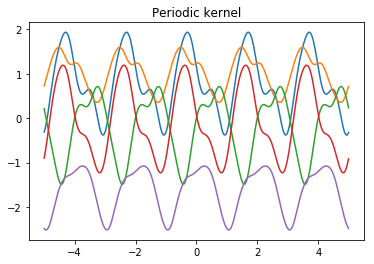

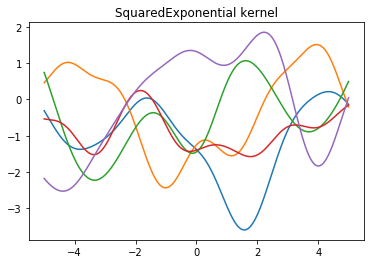

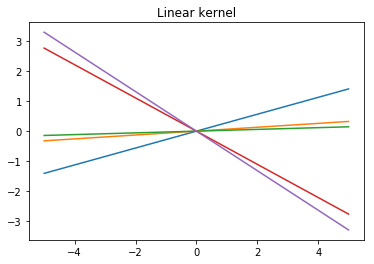

In [11]:
# Plot samples from the prior of each GP
for name, gp in gps.items():
    y_samples = gp.sample_prior(X_test, n_samples=5)
    plt.plot(X_test, y_samples)
    plt.title('{} kernel'.format(name))
    plt.show()

The plots should make clear that each sample drawn is an $n_*$-dimensional vector, containing the function values at each of the $n_*$ input points (there is one colored line for each sample).

By experimenting with the parameters for each of the different kernels, we can can change the characteristics of the sampled functions. The $\texttt{signal}\_\texttt{variance}$ parameter for the $\texttt{Linear}$ kernel controls the variance of the function gradients: small values give a narrow distribution of gradients around zero, and larger values the opposite. The $\texttt{length}\_\texttt{scale}$ parameter for the $\texttt{SquaredExponential}$ kernel roughly specifies how far apart two input points need to be before their corresponding function values can differ significantly: small values mean less 'co-variance' and so more quickly varying functions, whilst larger values mean more co-variance and so flatter functions. Finally the $\texttt{frequency}$ parameter of the periodic kernel specifies the inverse distance you have to move in input space before the function values repeat themselves: small values mean longer periods and large values the opposite. Note that I could have parameterised each of these functions more to control other aspects of their character e.g. the periodic kernel could also be given a length scale parameter to control the co-variance of function values within each periodic element.

### Sampling from the GP posterior

So far we have only drawn functions from the GP prior. In order to make meaningful predictions, we first need to restrict this prior distribution to contain only those functions that agree with the observed data. In other words we need to form the GP posterior. 

The f.d.d of the observations $\mathbf{y} \sim \mathbb{R}^n$ defined under the GP prior is:
$$\mathbf{y} \sim \mathcal{N}\left(\mathbf{0}, K(X, X) + \sigma_n^2I\right).$$

The additional term $\sigma_n^2I$ is due to the fact that our observations are assumed noisy as mentioned above. We assume that this noise is independent and identically distributed for each observation, hence it is only added to the diagonal elements of $K(X, X)$. 

Using the [marginalisation property](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Marginal_distributions) of multivariate Gaussians, the joint distribution over the observations, $\mathbf{y}$, and test outputs $\mathbf{f_*}$ according to the GP prior is
$$\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} = \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} K(X, X)  + \sigma_n^2I && K(X, X_*) \\ K(X_*, X) && K(X_*, X_*)\end{bmatrix}\right).$$

The GP posterior is found by conditioning the joint G.P prior distribution on the observations
$$\mathbf{f}_* | X_*, X, \mathbf{y} \sim \mathcal{N}\left(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)\right),$$

where 
\begin{align*}
\bar{\mathbf{f}}_* &= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*).
\end{align*}

Although $\bar{\mathbf{f}}_*$ and $\text{cov}(\mathbf{f}_*)$ look nasty, they follow the the standard form for the mean and covariance of a conditional Gaussian distribution, and can be derived relatively straightforwardly (see [here](https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution)).

We sample functions from our GP posterior in exactly the same way as we did from the GP prior above, but using posterior mean and covariance in place of the prior mean and covariance. Terms involving the matrix inversion $\left[K(X, X) + \sigma_n^2\right]^{-1}$ are handled using the Cholesky factorization of the positive definite matrix $[K(X, X) + \sigma_n^2] = L L^T$. In particular we first pre-compute the quantities $\mathbf{\alpha} = \left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} = L^T \backslash(L \backslash \mathbf{y})$ and $\mathbf{v} = L^T [K(X, X) + \sigma_n^2]^{-1}K(X, X_*) = L \backslash K(X, X_*)$,
before computing the posterior mean and covariance as
$\bar{\mathbf{f}}_* = K(X, X_*)^T\mathbf{\alpha}$ and $\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - \mathbf{v}^T\mathbf{v}$.

In [12]:
def sample_posterior(self, X_train, y_train, X_test, n_samples=1):
    
    # compute alpha
    K = self._build_covariance_matrix(X_train)
    K[np.diag_indices_from(K)] += self.noise_var
    L = self._cholesky_factorise(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    # Compute posterior mean
    K_trans = self._build_covariance_matrix(X_test, X_train)
    y_mean = K_trans.dot(alpha)
   
    # Compute posterior covariance
    v = np.linalg.solve(L, K_trans.T)  # L.T * K_inv * K_trans.T
    y_cov = self._build_covariance_matrix(X_test) - np.dot(v.T, v)
    
    return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples), y_mean, y_cov
    
GPR.sample_posterior = sample_posterior

Let's have a look at some samples drawn from the posterior of our Squared Exponential GP. For observations, we'll use samples from the prior. 

In [13]:
# Define GP
gp = gps['SquaredExponential']

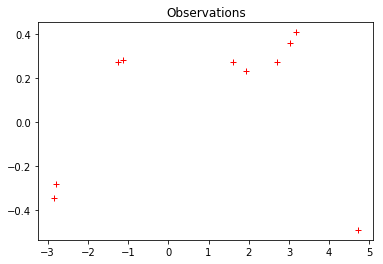

In [14]:
# Generate observations using a sample drawn from the prior.
X_train = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
y_train = gp.sample_prior(X_train)
y_train = y_train[:, 0]  # Only one sample

plt.plot(X_train[:, 0], y_train, 'r+')
plt.title('Observations')
plt.show()

In [15]:
# Generate posterior samples, saving the posterior mean and covariance too.
f_star_samples, f_star_mean, f_star_covar = gp.sample_posterior(X_train, y_train, X_test, n_samples=10)

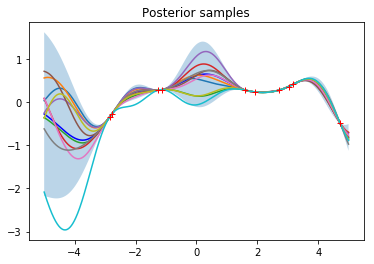

In [16]:
# Plot poterior mean and 95% confidence interval.
pointwise_variances = f_star_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
plt.plot(X_test, f_star_mean, 'b')
plt.fill_between(X_test[:, 0], f_star_mean - error, f_star_mean + error, alpha=0.3)

# Plot samples from posterior
plt.plot(X_test, f_star_samples)

# Also plot our observations for comparison
plt.plot(X_train[:, 0], y_train, 'r+')

plt.title('Posterior samples')
plt.show()

As you can see, the posterior samples all pass directly through the observations. This is because the noise variance of the GP was set to it's default value of $10^{-8}$ during instantiation. Increasing the noise variance allows the function values to deviate more from the observations, as can be verified by changing the $\texttt{noise}\_\texttt{var}$ parameter and re-running the code.

Away from the observations the data lose their influence on the prior and the variance of the function values increases. We know to place less trust in the model's predictions at these locations.

### Optimizing the kernel parameters

Of course the reliability of our predictions is dependent on a judicious choice of kernel function. We cheated in the above because we generated our observations from the same G.P that we formed the posterior from, so we knew our kernel was a good choice! Still, picking a sub-optimal kernel function is not as bad as picking a sub-optimal set of basis functions in standard regression setup: a given kernel function covers a much broader distribution of functions than a given set of basis functions. In fact, the Squared Exponential kernel function that we used above corresponds to a Bayesian linear regression model with an _infinite_ number of basis functions, and is a common choice for a wide range of problems. [Chapter 4 of Rasmussen and Williams](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) covers some other choices, and their potential use cases.

Even once we've made a judicious choice of kernel function, the next question is how do we select it's parameters? If you played with the kernel parameters above you would have seen how much influence they have. For example the kind of functions that can be modelled with a Squared Exponential kernel with a length scale of 10 are completely different (much flatter) than those that can be modelled with the same kernel but a length scale of 1. Luckily, Bayes' theorem provides us a principled way to pick the optimal parameters.

By Bayes' theorem, the posterior distribution over the kernel parameters $\pmb{\theta}$ is given by:

$$ p(\pmb{\theta}|\mathbf{y}, X) = \frac{p(\mathbf{y}|X, \pmb{\theta}) p(\pmb{\theta})}{p(\mathbf{y}|X)}.$$

The maximum a posteriori (MAP) estimate for $\pmb{\theta}$, $\pmb{\theta}_{MAP}$, occurs when $p(\pmb{\theta}|\mathbf{y}, X)$ is greatest. Usually we have little prior knowledge about $\pmb{\theta}$, and so the prior distribution $p(\pmb{\theta})$ can be assumed flat. In this case $\pmb{\theta}_{MAP}$ can be found by maximising the marginal likelihood, $p(\mathbf{y}|X, \pmb{\theta}) = \mathcal{N}(\mathbf{0}, K(X, X) + \sigma_n^2I)$, which is just the f.d.d of our observations under the GP prior (see above). The term _marginal_ refers to the marginalisation over the function values $\mathbf{f}$. It is common practice, and equivalent, to maximise the log marginal likelihood instead:

$$\text{log}p(\mathbf{y}|X, \pmb{\theta}) = -\frac{1}{2}\mathbf{y}^T\left[K(X, X) + \sigma_n^2I\right]^{-1}\mathbf{y} - \frac{1}{2}\text{log}\lvert K(X, X) + \sigma_n^2I \lvert - \frac{n}{2}\text{log}2\pi.$$

To do this we can simply plug the above expression into a multivariate optimizer of our choosing, e.g. L-BFGS. 

In terms of implementation, we already computed $\mathbf{\alpha} = \left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y}$ when dealing with the posterior distribution. The only other tricky term to compute is the one involving the determinant. Here our Cholesky factorisation $[K(X, X) + \sigma_n^2] = L L^T$ comes in handy again:
$$\lvert K(X, X) + \sigma_n^2 \lvert = \lvert L L^T \lvert = \prod_{i=1}^n L_{ii}^2 \quad \text{or} \quad \text{log}\lvert{K(X, X) + \sigma_n^2}\lvert = 2 \sum_i^n \text{log}L_{ii}$$
Let's define the methods to compute and optimize the log marginal likelihood in this way.

In [17]:
def log_marginal_likelihood(self, X_train, y_train, theta, noise_var=None):
    
    if noise_var is None:
        noise_var = self.noise_var
    
    # Build K(X, X)
    self.kernel.theta = theta
    K = self._build_covariance_matrix(X_train)    
    K[np.diag_indices_from(K)] += noise_var
       
    # Compute L and alpha for this K (theta).
    L = self._cholesky_factorise(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
        
    # Compute log marginal likelihood.
    log_likelihood = -0.5 * np.dot(y_train.T, alpha)
    log_likelihood -= np.log(np.diag(L)).sum()
    log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)
    
    return log_likelihood
GPR.log_marginal_likelihood = log_marginal_likelihood

In [18]:
def optimize(self, X_train, y_train):
    
    def obj_func(theta, X_train, y_train):
            return -self.log_marginal_likelihood(X_train, y_train, theta)
  
    results = minimize(obj_func, 
                       self.kernel.theta, 
                       args=(X_train, y_train), 
                       method=self.optimizer, 
                       jac=None,
                       bounds=self.kernel.bounds)

    # Store results of optimization.
    self.max_log_marginal_likelihood_value = -results['fun']
    self.kernel.theta_MAP = results['x']
    
    return results['success']

GPR.optimize = optimize

We can now compute the $\pmb{\theta}_{MAP}$ for our Squared Exponential GP. In this case $\pmb{\theta}=\{l\}$, where $l$ denotes the length scale parameter. 

In [19]:
success = gp.optimize(X_train, y_train)
if success:
    print('MAP estimate of theta is {}. Maximised log marginal liklehihood is {}.'.format(gp.kernel.theta_MAP, gp.max_log_marginal_likelihood_value))
else:
    print('Optimization failed. Try setting different initial value of theta.')

MAP estimate of theta is [ 1.08685909]. Maximised log marginal liklehihood is 2.371196628044073.


Of course there is no guarantee that we've found the global maximum. It's likely that we've found just one of many local maxima. Still, $\pmb{\theta}_{MAP}$ is usually a good estimate, and in this case we can see that it is very close to the $\pmb{\theta}$ used to generate the data, which makes sense. We can get get a feel for the positions of any other local maxima that may exist by plotting the contours of the log marginal likelihood as a function of $\pmb{\theta}$. If we allow $\pmb{\theta}$ to include the noise variance as well as the length scale, $\pmb{\theta} = \{l, \sigma_n^2\}$, we can check for maxima along this dimension too. 

In [20]:
# Create coordinates in parameter space at which to evaluate the lml.
length_scales = np.linspace(0.8, 1.4, 100)
noise_variance = np.linspace(1e-12, 1e-2, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [21]:
# Evaluate the lml at these coordinates.
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(X_train, y_train, theta=[x[0]], noise_var=x[1]), list(zip(X.ravel(), Y.ravel())))))
Z = Z.reshape((X.shape))

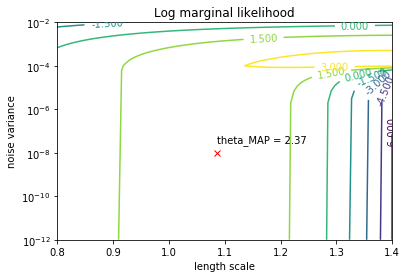

In [22]:
# Plot the contours.
fig, ax = plt.subplots()
ax.set_yscale('log')
levels = np.arange(-3, 3, 0.25)
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(gp.kernel.theta_MAP[0], gp.noise_var, color='red', marker='x')
plt.annotate('theta_MAP = {:.2f}'.format(
    gp.max_log_marginal_likelihood_value), xy=(gp.kernel.theta_MAP[0], gp.noise_var + 2e-8))
plt.title('Log marginal likelihood')
plt.xlabel('length scale')
plt.ylabel('noise variance')
plt.show()

The red cross marks the position of $\pmb{\theta}_{MAP}$ for our G.P with fixed noised variance of $10^{-8}$. We can see that there is another local maximum if we allow the noise to vary, at around $\pmb{\theta}=\{1.35, 10^{-4}\}$. In other words, we can fit the data just as well (in fact better) if we increase the length scale but also increase the noise variance i.e. choose a function with a more slowly varying signal but more flexibility around the observations.

Convergence of this optimization process can be improved by passing the gradient of the objective function (the Jacobian) to $\texttt{minimize}$ as well as the objective function itself. This gradient will only exist if the kernel function is differentiable within the bounds of theta, which is true for the Squared Exponential kernel (but may not be for other more exotic kernels). [Chapter 5 of Rasmussen and Williams](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf) provides the necessary equations to calculate the gradient of the objective function in this case.

Of course in a full Bayesian treatment we would avoid picking a point estimate like $\pmb{\theta}_{MAP}$ at all. Instead, at inference time we would integrate over all possible values of $\pmb{\theta}$ allowed under $p(\pmb{\theta}|\mathbf{y}, X)$. Once again [Chapter 5 of Rasmussen and Williams](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf) outlines how to do this.

### Wrap-up

This post has hopefully helped to demystify some of the theory behind Gaussian Processes, explain how they can be applied to regression problems, and demonstrate how they may be implemented. We have only really scratched the surface of what GPs are capable of. For example, they can also be applied to classification tasks (see [Chapter 3 Rasmussen and Williams](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf)), although because a Gaussian likelihood is inappropriate for tasks with discrete outputs, analytical solutions like those we've encountered here do not exist, and approximations must be used instead. Still, a principled probabilistic approach to classification tasks is a very attractive prospect, especially if they can be scaled to high-dimensional image classification, where currently we are largely reliant on the point estimates of Deep Learning models.